In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot

%pip install mplfinance
import mplfinance as mpf

import sys
import importlib
sys.path.append('/content/drive/MyDrive/Colab Notebooks/April')

from pipelines import loaders, filters, interpolators, downloaders, url_generator

print("Imported Libraries")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imported Libraries


In [ ]:
tickers = ['AAPL']
yf_filepath = '/content/drive/MyDrive/Colab Notebooks/April/data/yf'
columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
ticker_historical = loaders.load_historicals(tickers, columns, yf_filepath)
ticker_historical = ticker_historical['AAPL']

### Check for Stationarity: ACF, PACF, Normal Distribution

In [ ]:
#Standardize our dataset so the values that we plug into our model are constrained within a range and repeatable, for any point in time
#I go over three common ways to introduce stationarity to the model below

def difference_by_previous_data(ticker_historical, periods=1): #Obviously this will not work as it does not constrain the dataset values, prices flucuate too much with time, just testing it
  ticker_diff = ticker_historical.diff(periods=periods).dropna()
  return ticker_diff

def difference_by_return_percentage(ticker_historical):
  ticker_diff = (((ticker_historical.shift(-1)-ticker_historical)/ticker_historical)*100) #Double check can we shift(1) flip here as with diff log returns
  shifted_index = ticker_diff.index[1:] #Shift index for log returns to be on the same day
  ticker_diff = ticker_diff.dropna()
  ticker_diff.index = shifted_index
  return ticker_diff
 
def difference_by_log_returns(ticker_historical, base=10):
  ticker_diff = (ticker_historical/ticker_historical.shift(1))
  if base == 10:
    ticker_diff = np.log10(ticker_diff)*100
  else:
    ticker_diff = np.log(ticker_diff)
  ticker_diff = ticker_diff.dropna()
  return ticker_diff

def plot_stationary_graphs(ticker_diff):
  %matplotlib inline
  figure_dims = (20, 10)
  fig, ax = plt.subplots(2,2, figsize=figure_dims)
  sns.set_style('whitegrid')
  ax[0][0] = autocorrelation_plot(ticker_diff, ax=ax[0][0])
  ax[0][1] = plot_pacf(ticker_diff, ax=ax[0][1])
  ax[1][0] = sns.histplot(data=ticker_diff, ax=ax[1][0])
  sm.qqplot(ticker_diff, line='45', ax=ax[1][1])
  print(ticker_diff.describe())
  print('Skewness is {}'.format(ticker_diff.skew()))
  print('Kurtosis is {}'.format(ticker_diff.kurtosis()))
  plt.show()

Lag 1 Day Differences

count    3775.000000
mean        0.044276
std         0.968080
min       -10.437553
25%        -0.134173
50%         0.015306
75%         0.193814
max         9.973083
Name: Close, dtype: float64
Skewness is -0.07007493169114257
Kurtosis is 21.934033752894784


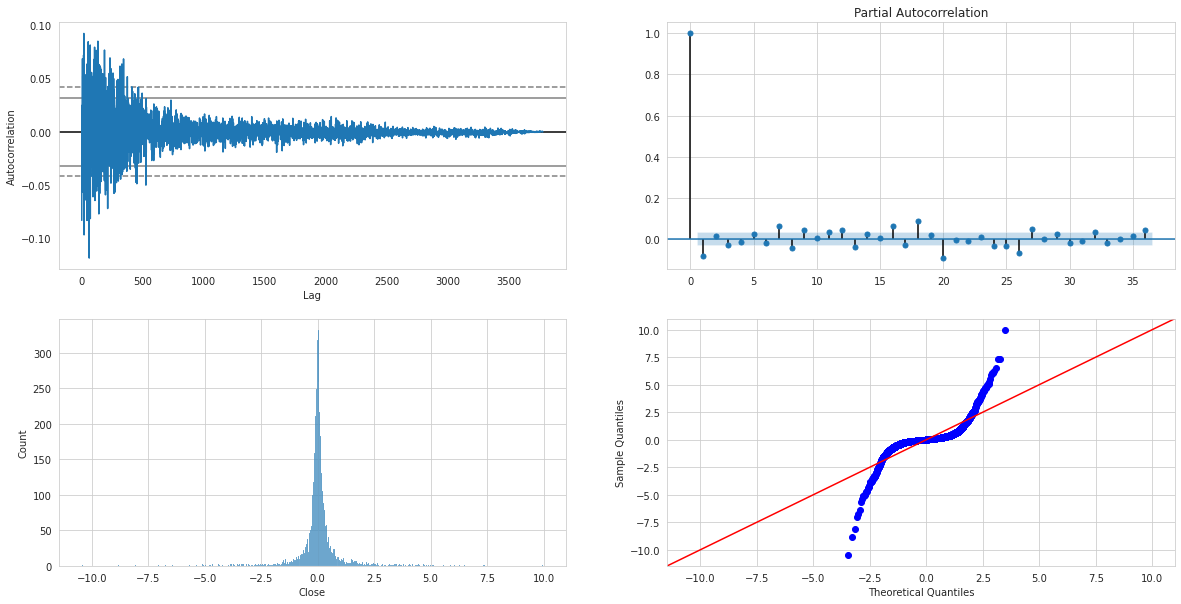

In [ ]:
print("Lag 1 Day Differences\n")
ticker_lag_diff = difference_by_previous_data(ticker_historical)['Close']
plot_stationary_graphs(ticker_lag_diff)

Return Differences

count    3775.000000
mean        0.130529
std         2.014431
min       -17.919511
25%        -0.777123
50%         0.111234
75%         1.156911
max        13.904946
Name: Close, dtype: float64
Skewness is -0.17752448783812497
Kurtosis is 6.31397495451905


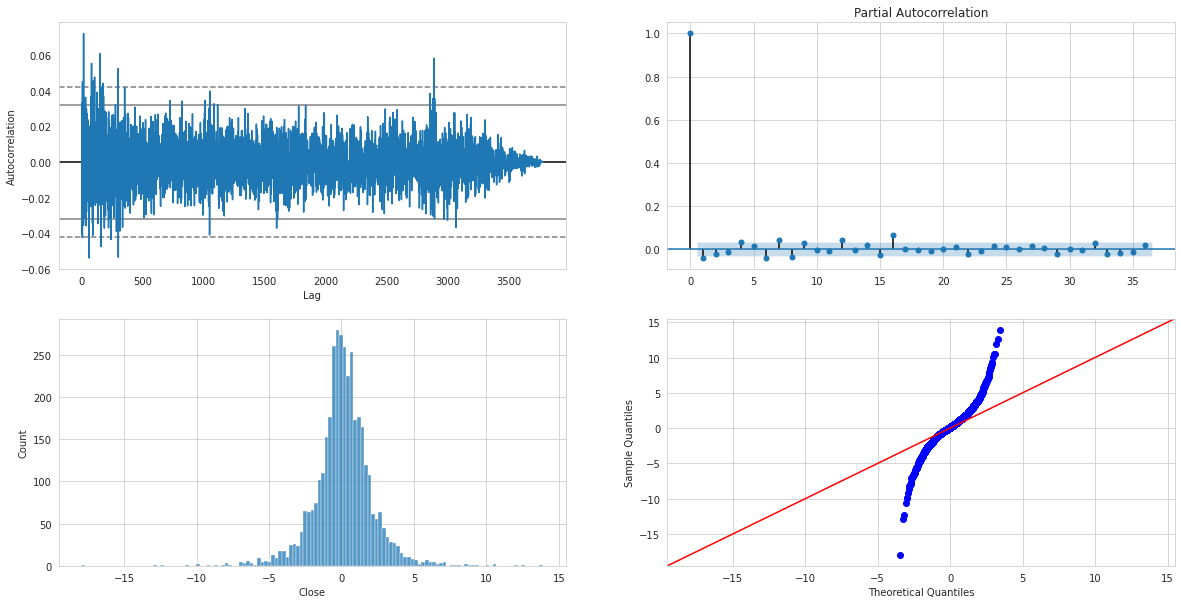

In [ ]:
print("Return Differences\n")
ticker_return_diff = difference_by_return_percentage(ticker_historical)['Close'].drop(columns='Volume') #Drop volume for convenince, won't be using it here
plot_stationary_graphs(ticker_return_diff)

Log Differences

count    3775.000000
mean        0.047827
std         0.876789
min        -8.576007
25%        -0.338818
50%         0.048281
75%         0.499556
max         5.654258
Name: Close, dtype: float64
Skewness is -0.4373639508043117
Kurtosis is 7.058346755172531


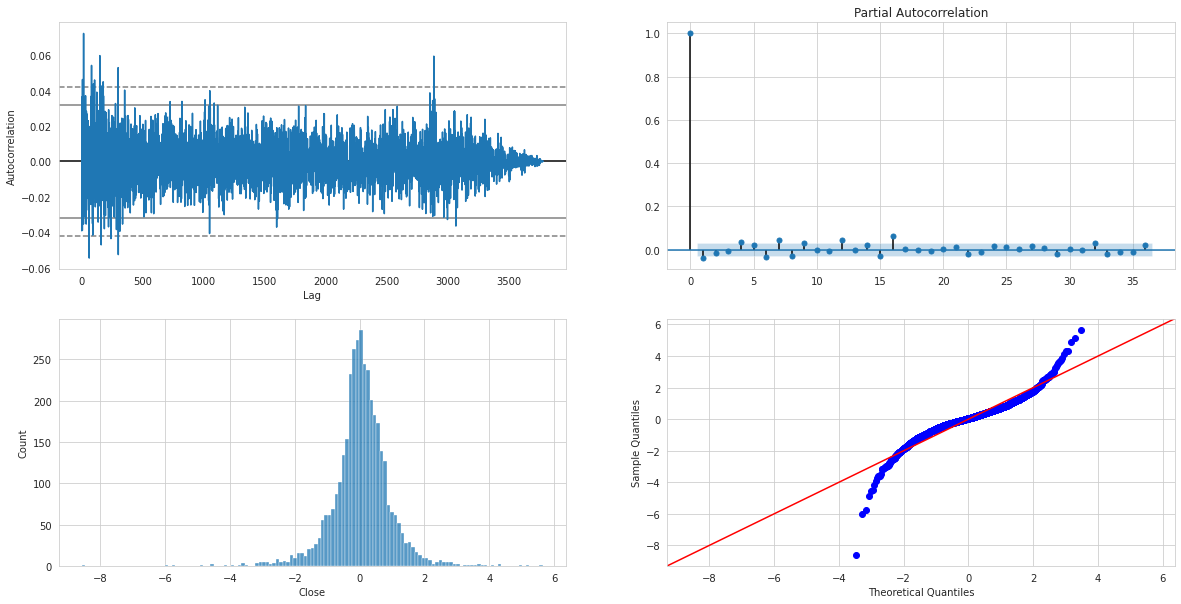

In [ ]:
print("Log Differences\n")
# At some point we will have to look into natural log base vs log10 base
ticker_log_diff = difference_by_log_returns(ticker_historical, base=10).drop(columns='Volume') 
plot_stationary_graphs(ticker_log_diff['Close'])

In [ ]:
#From above 1 day lag differences are the worst standard deviations for the plot, this should be understandable
#Because as the price of the stock increases previous differences of the stock grow larger, which dont follow a normal distribution
#Standard day-to-day returns are not bad but the QQ plot of them look poor and although it has a lower kurtosis than log returns, the standard deviation and mean is higher
#Log returns look like the best normal distributions as seen on our QQ plot, additionally there are also sum and sum-product characteristics, these are favorable from a log return distribution
#Let's inspect this further though and see how events and a day-to-day basis could affect these returns

### OHLC Distributions and Sequence Lengths

In [ ]:
#Information on the distributions of the OHLC data
def calculate_ci(diff, z_score=1.96): #1.96 is 95% CI, 1.64 for 90% CI
  upper_ci = diff.mean() + z_score*diff.std()
  lower_ci = diff.mean() - z_score*diff.std()
  return upper_ci, lower_ci

ohlc_mean = ticker_log_diff.mean()
ohlc_std = ticker_log_diff.std()
ohlc_kurtosis = ticker_log_diff.kurtosis()
ohlc_skew = ticker_log_diff.skew()

for ohlc in ticker_log_diff.columns:
  print("For {}:\nMean is {}\nStandard Deviation is {}\nKurtosis is {}\nSkew is {}".format(ohlc,
                                                                                           ohlc_mean[ohlc],
                                                                                           ohlc_std[ohlc],
                                                                                           ohlc_kurtosis[ohlc],
                                                                                           ohlc_skew[ohlc]))
  upper_ci, lower_ci = calculate_ci(ticker_log_diff[ohlc])
  print("With Lower Bound {} and Upper Bound {}\n".format(lower_ci, upper_ci))

For Open:
Mean is 0.047634677337430056
Standard Deviation is 0.9260053651223643
Kurtosis is 7.484266300202107
Skew is -0.06794489876007118
With Lower Bound -1.7673358383024038 and Upper Bound 1.862605192977264

For High:
Mean is 0.04770097704416139
Standard Deviation is 0.7284898758313306
Kurtosis is 5.896916574447632
Skew is 0.006302718312712348
With Lower Bound -1.3801391795852467 and Upper Bound 1.4755411336735695

For Low:
Mean is 0.04795241986416867
Standard Deviation is 0.8692852878758786
Kurtosis is 13.073653012461055
Skew is -0.76331610297239
With Lower Bound -1.655846744372553 and Upper Bound 1.7517515841008906

For Close:
Mean is 0.047826760473405824
Standard Deviation is 0.8767888001933646
Kurtosis is 7.058346755172531
Skew is -0.4373639508043117
With Lower Bound -1.6706792879055887 and Upper Bound 1.7663328088524002



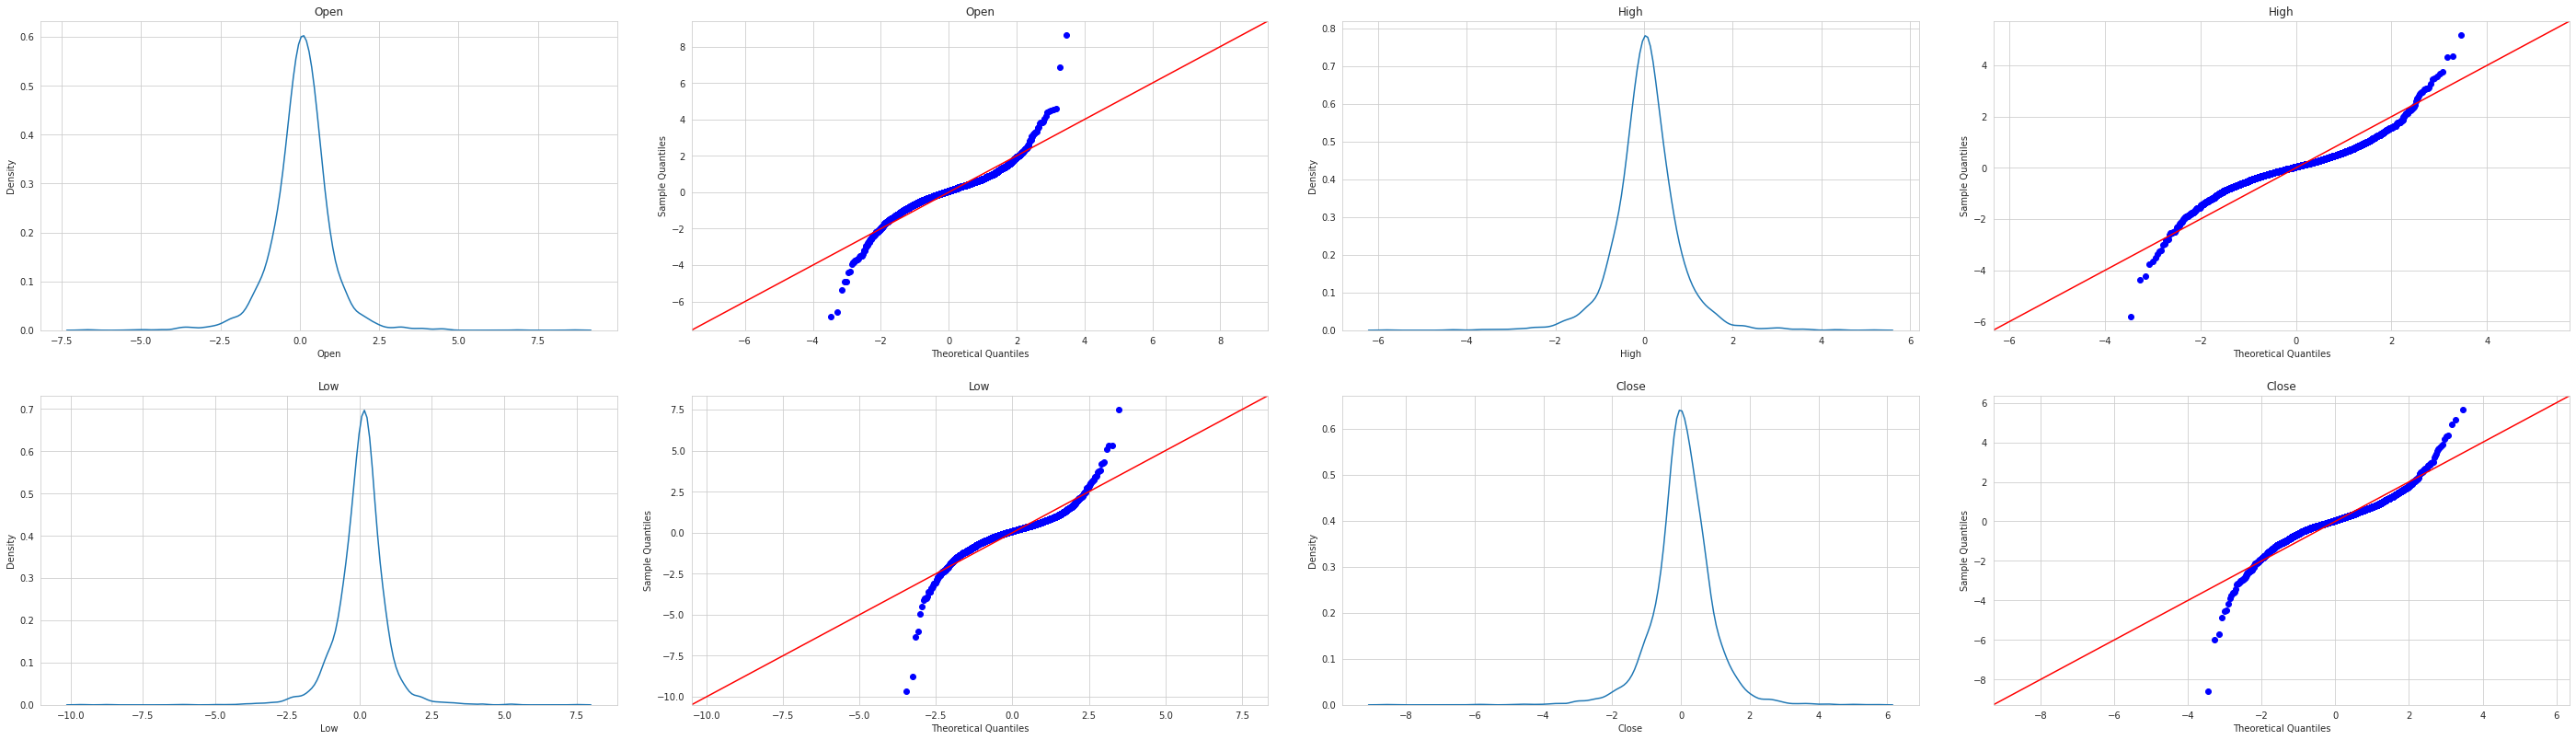

In [ ]:
#Plotting the OHLC distribution curves with Normal Standard and QQ plots
#Should constrain to same xlimits and ylimits

figure_dims = (40, 12)
fig, ax = plt.subplots(2,4, figsize=figure_dims)
fig.tight_layout(pad=5)

for count, ohlc in enumerate(ticker_log_diff.columns):
  if count < 2:
    row_loc = 0
  else:
    row_loc = 1
  if count%2 == 0:
    col_loc = 0
  else:
    col_loc = 2

  ax[row_loc][col_loc] = sns.kdeplot(data=ticker_log_diff[ohlc], x=ticker_log_diff[ohlc], ax=ax[row_loc][col_loc])
  _ = ax[row_loc][col_loc].set_title(ohlc)

  col_loc = col_loc + 1
  sm.qqplot(ticker_log_diff[ohlc], line='45', ax=ax[row_loc][col_loc])
  _ = ax[row_loc][col_loc].set_title(ohlc)

count    3756.000000
mean        0.972835
std         3.970710
min       -23.557710
25%        -1.069429
50%         1.254250
75%         3.536759
max        15.388179
Name: Close, dtype: float64
Skewness is -1.0550001678201932
Kurtosis is 3.7435465641525782


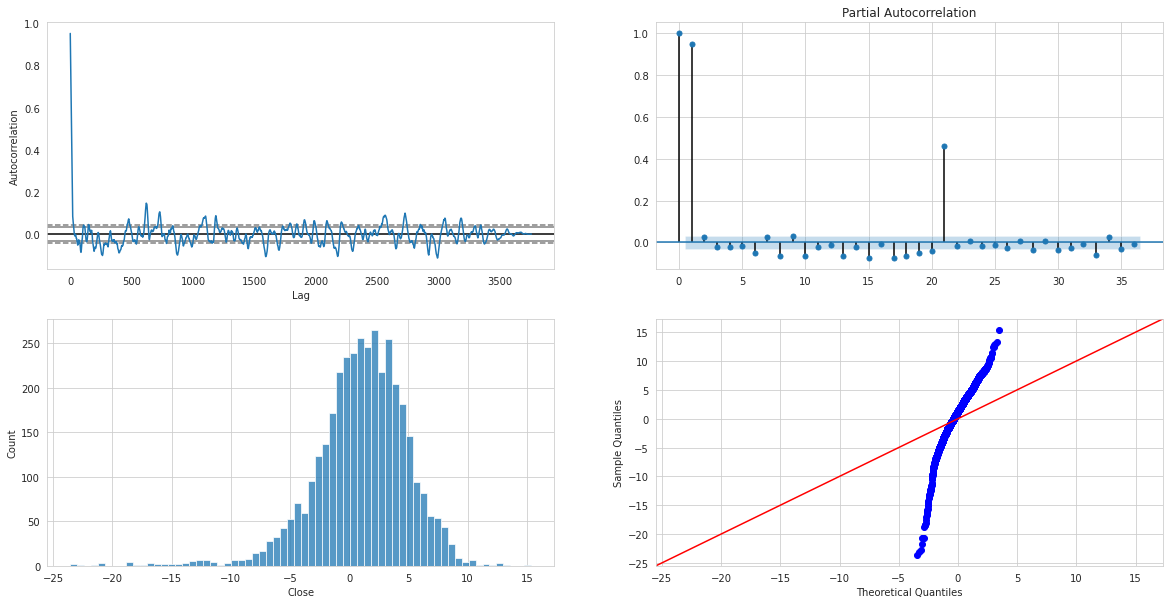

In [ ]:
#Going back to Close pricing, lets create a window to see if there are correlations within time periods
holding_period = 20
summed_close_sequences = ticker_log_diff['Close'].rolling(window=holding_period).sum().dropna() #drops first 19 until there is a full window to sum up
plot_stationary_graphs(summed_close_sequences)

count    3756.000000
mean        0.973420
std         3.930409
min       -22.237678
25%        -1.124378
50%         1.268998
75%         3.547763
max        14.171485
dtype: float64
Skewness is -0.9825163101546514
Kurtosis is 3.2642924223148313


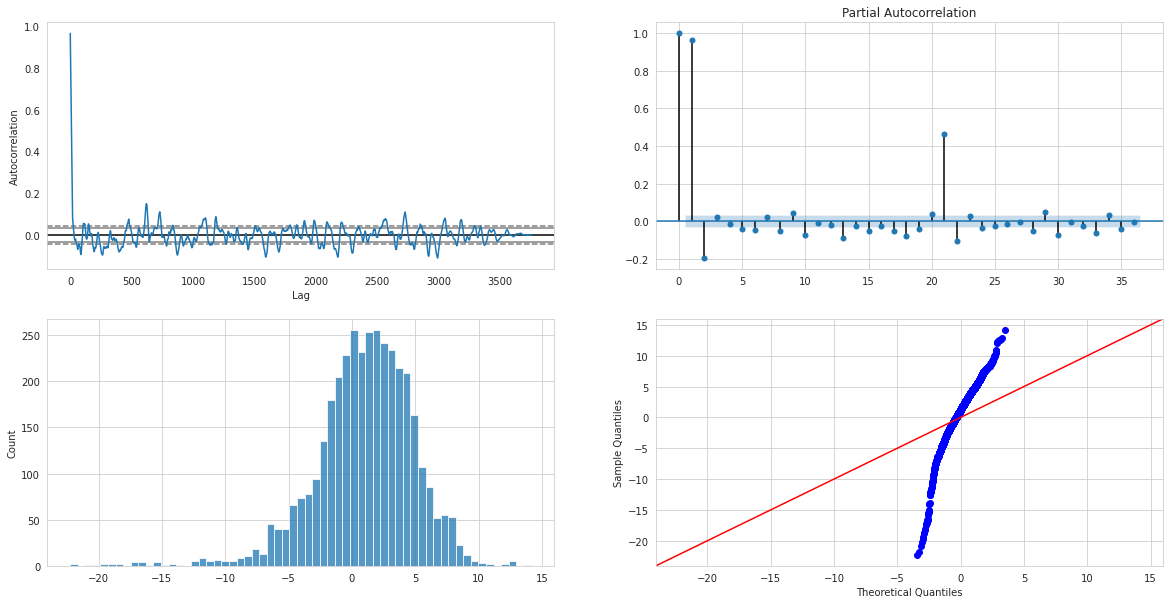

In [ ]:
#Scrambling OHLC, do we keep the positive leaning distribution
#Let's attempt this 1000 times since it is random

def sample_ohlc_scramble(dataset,
                         trials,
                         holding_period):
  scrambled_ohlc = []
  for rng_seed in range(0, trials):
    rng = np.random.default_rng(seed=rng_seed)
    random_choice = lambda x: rng.choice(x)
    trial_ohlc_scramble = dataset.apply(random_choice, axis=1)
    rolling_window = trial_ohlc_scramble.rolling(window=holding_period).sum().dropna().tolist()
    scrambled_ohlc.append(rolling_window)
  scrambled_ohlc = pd.DataFrame(scrambled_ohlc).mean()  # We are taking the mean of our results
  return scrambled_ohlc

trials = 50
scrambled_ohlc = sample_ohlc_scramble(ticker_log_diff,
                                      trials, 
                                      holding_period)
plot_stationary_graphs(scrambled_ohlc)

In [ ]:
#From above, as expected if you hold the stock for a long-term the mean is positive as the stock prices trends upwards
#However, independent events holding the stock for a single day gives a mean of zero and returns will be sampled from a normal distribution
#Additionally, you can scramble the OHLC's to create more examples in the train dataset as they have very similar normal distribution statistics

### Isolate Outliers, Heavy Tails, and High Kurtosis

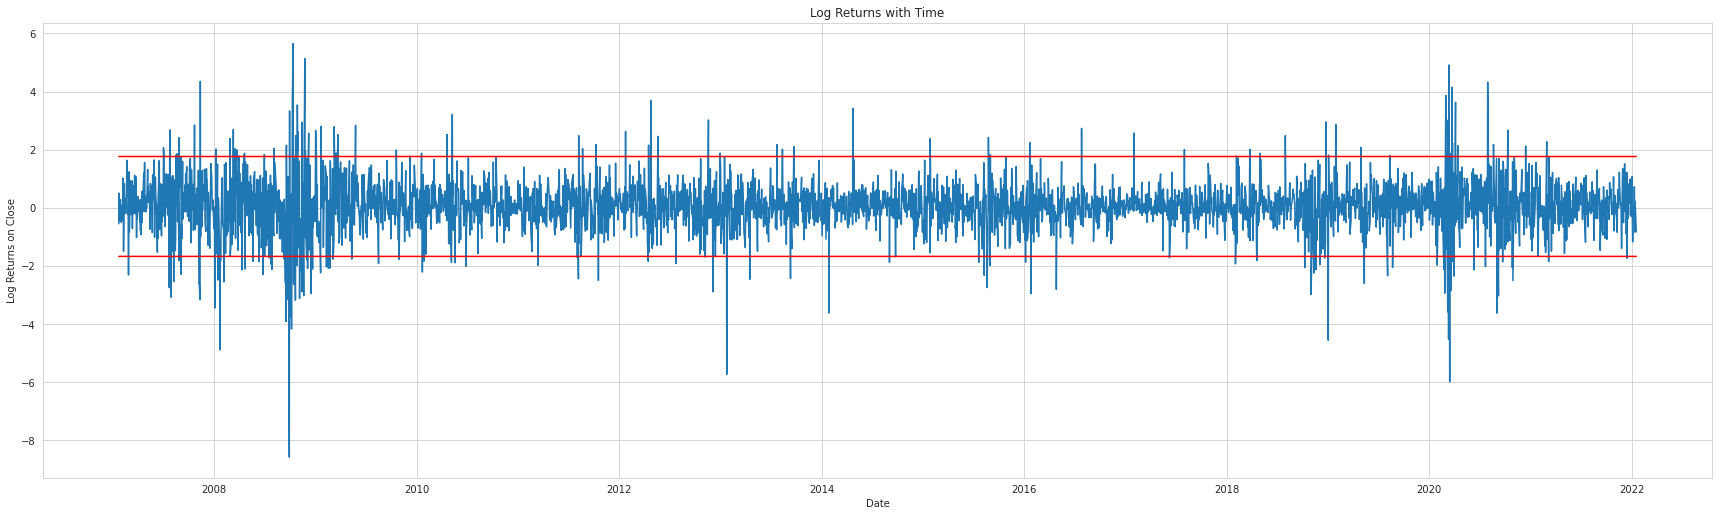

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
fig.tight_layout(pad=5)
sns.set_style('whitegrid')
ax = sns.lineplot(data=ticker_log_diff,
                     x=ticker_log_diff.index, 
                     y='Close')

upper_log_bound, lower_log_bound = calculate_ci(ticker_log_diff['Close']) #Bounds are the same for natural log and log10 normalization
ax.errorbar(x=ticker_log_diff.index, y=upper_log_bound, color='r')
ax.errorbar(x=ticker_log_diff.index, y=lower_log_bound, color='r')
_ = ax.set(title="Log Returns with Time", ylabel='Log Returns on Close')

In [ ]:
# Can use z-score to highlight outliers, or qq plot and track when it falls out of line from the normali distribution

In [ ]:
#Collect date oustside of confidence interval, outliers will be anything over our z-score confidence interval
#Then save the dates for later analysis in market EDA or for possible anamoly detection later, let's drop it into a json file

def save_pd_to_json(df, filepath):
  df.to_json(filepath)

log_diff_95_outliers = (ticker_log_diff[(upper_log_bound < ticker_log_diff['Close']) | (lower_log_bound > ticker_log_diff['Close'])]).dropna()
filepath = '/content/drive/MyDrive/Colab Notebooks/GitHub/Preparing-a-Machine-Learning-Pipeline-for-Stock-Data/Part 1 - EDA/logdiff95outliers.json'
display(log_diff_95_outliers)
#save_pd_to_json(log_diff_95_outliers, filepath)

Open      High       Low     Close     Volume
Year Month                                                     
2007 2007-02 -1.745882 -1.432412 -2.133550 -2.307504  26.963972
     2007-07  0.339528  1.848960  0.793608  2.066737   6.762307
     2007-07  2.355597  1.858421  2.496840  1.864974   9.689495
     2007-07 -1.363683 -1.280743 -2.141286 -2.747708  23.857017
     2007-07  2.625635  3.071580  0.625996  2.680883  16.479049
...                ...       ...       ...       ...        ...
2020 2020-10 -0.509277 -1.874675 -1.769653 -2.503634  11.463925
     2020-12  0.612043  1.573145  0.915756  2.122670  29.793308
2021 2021-03  0.409020  1.058389  0.566042  2.277933 -15.071612
     2021-03 -0.017956 -0.336085 -0.505304 -1.848652   0.171946
     2021-12  1.022089  0.394991 -0.394976 -1.739587   5.914777

[204 rows x 5 columns]

### Check Volatility of the Stock

In [ ]:
#Changing volatilty of the stock
#At 60, 40, 20, 1 day
#Overall trends by month and by year

 #HV=HVdaily*sqrt(252) #Yearly volatility, do we use log returns or just prices, double check difference

### Average Returns Per Year and Month

In [ ]:
#Averge Returns per Month and Year, set aside for now, will use it later
ticker_log_diff = difference_by_log_returns(ticker_historical)
year_index = ticker_log_diff.index.year.rename('Year')
month_index = ticker_log_diff.index.strftime('%Y-%m').rename('Month')
ticker_log_diff = ticker_log_diff.set_index([year_index, month_index])

def get_yearly_monthly_returns(returns_df, year_index):
  yearly_returns = []
  monthly_returns = []
  years = year_index.unique()
  months = []

  for year in years:
    yearly_returns.append(returns_df.loc[year, 'Close'].sum())
    months_in_year = ticker_log_diff.loc[year, 'Close'].index.unique() #Get all the months of data for each year
    for month in months_in_year:
      monthly_returns.append(returns_df.loc[(year, month), 'Close'].sum())
      months.append(month)

  yearly_returns = pd.DataFrame(yearly_returns, index=years, columns=['Avg Returns'])
  monthly_returns = pd.DataFrame(monthly_returns, index=months, columns=['Avg Returns'])
  return yearly_returns, monthly_returns

yearly_returns, monthly_returns = get_yearly_monthly_returns(ticker_log_diff, year_index)

### Correlations of Volatilty, Volume, and Returns

In [ ]:
#Volatility of different OHLC prices
#I believe open price is more volatile than close

### Earning Dates Vs Volatility Correlations and Avg Returns

In [ ]:
#That's it for now
#Well not much to gain here, just the chaacteristic of the stock
#We will look into usign indicators and their analysis once we start Feature Engineering

In [ ]:
#Heatmap correlations between OHLC and Volumes
#Look into volumes on log basis or changep percent per past day
#Do we need to plot volumes

### Correlations of OHLC

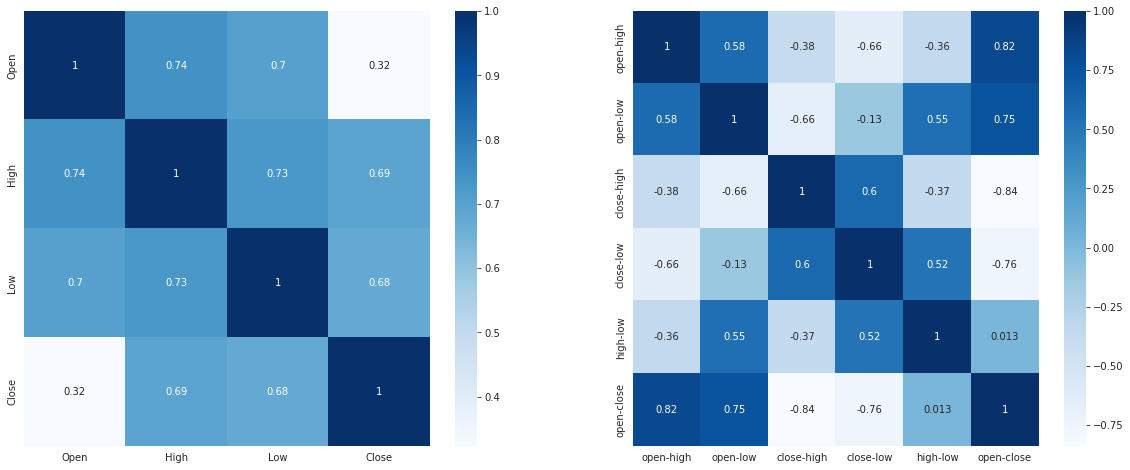

In [ ]:
#In practice and for the machine learning model we will do different normalization for volume
#It will need to keep volume within a range and of similar magnitude to our other features

ticker_log_diff = difference_by_log_returns(ticker_historical)
ticker_log_diff = ticker_log_diff.drop(columns=['Volume'])

def create_ohlc_diff_correlations(df):
  df = df.copy()
  df['open-high'] = df['Open']-df['High']
  df['open-low'] = df['Open'] - df['Low']
  df['close-high'] = df['Close']-df['High']
  df['close-low'] = df['Close'] - df['Low']
  df['high-low'] = df['High'] - df['Low']
  df['open-close'] = df['Open'] - df['Close']
  df = df.drop(columns=['Open', 'High', 'Low', 'Close'])
  df = df.corr()
  return df
  
ohlc_correlations = ticker_log_diff.corr()
ohlc_diff_correlations = create_ohlc_diff_correlations(ticker_log_diff)

fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0] = sns.heatmap(ohlc_correlations, 
                 cmap='Blues', 
                 annot=True, 
                 ax=ax[0])
ax[1] = sns.heatmap(ohlc_diff_correlations, 
                 cmap='Blues',
                 annot=True, 
                 ax=ax[1])

#Try pd.corrwith() with both

In [ ]:
#Lowest correlations given by Open and Close, indicates a higher chance of reversal compared to the others
#Will have to think about the other heatmap that utilizes differences, should we correlate differences against regular OHLC